## 🔹 GASA - Genetic Algorithm with Simulated Annealing


In [9]:
import numpy as np
import random
import math
from typing import List, Tuple

class GASA_mTSP:
    def __init__(self, distance_matrix: np.ndarray, m: int = 3,
                 pop_size: int = 100, generations: int = 300,
                 pc: float = 0.8, pm: float = 0.1,
                 sa_T0: float = 100, sa_alpha: float = 0.95, sa_Tmin: float = 1e-3):
        
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.m = m
        self.pop_size = pop_size
        self.generations = generations
        self.pc = pc
        self.pm = pm
        self.depot = 0

        # SA parameters
        self.sa_T0 = sa_T0
        self.sa_alpha = sa_alpha
        self.sa_Tmin = sa_Tmin

    # ---------------- Step 1: Initialization ----------------
    def initialize_population(self) -> List[List[int]]:
        cities = list(range(1, self.n_cities))
        return [random.sample(cities, len(cities)) for _ in range(self.pop_size)]

    # ---------------- Decode chromosome into m routes ----------------
    def decode_solution(self, chromosome: List[int]) -> List[List[int]]:
        routes = [[] for _ in range(self.m)]
        for i, city in enumerate(chromosome):
            routes[i % self.m].append(city)
        return routes

    # ---------------- Step 2: Fitness ----------------
    def calculate_fitness(self, chromosome: List[int]) -> float:
        routes = self.decode_solution(chromosome)
        route_distances = [
            sum(self.distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1))
            if len(route) > 1 else 0
            for route in [[self.depot] + r + [self.depot] for r in routes]
        ]
        return max(route_distances) if route_distances else float('inf')

    # ---------------- Step 3A: Selection (Roulette Wheel) ----------------
    def tournament_selection(self, population: List[List[int]], fitness: List[float]) -> List[int]:
        total_fitness = sum(1.0 / (f + 1e-6) for f in fitness)
        pick = random.uniform(0, total_fitness)
        current = 0
        for ind, fit in zip(population, fitness):
            current += 1.0 / (fit + 1e-6)
            if current >= pick:
                return ind.copy()
        return population[-1].copy()

    # ---------------- Step 3B: Order-based Crossover (OX) ----------------
    def partially_mapped_crossover(self, p1: List[int], p2: List[int]) -> Tuple[List[int], List[int]]:
        if random.random() > self.pc:
            return p1.copy(), p2.copy()
        size = len(p1)
        start, end = sorted(random.sample(range(size), 2))
        
        def ox(parent1, parent2):
            child = [None] * size
            child[start:end] = parent1[start:end]
            pos = end
            for city in parent2[end:] + parent2[:end]:
                if city not in child:
                    if pos >= size:
                        pos = 0
                    child[pos] = city
                    pos += 1
            return child
        
        return ox(p1, p2), ox(p2, p1)

    # ---------------- Step 3C: Scramble Mutation ----------------
    def index_mutation(self, chromosome: List[int]) -> List[int]:
        if random.random() < self.pm:
            start, end = sorted(random.sample(range(len(chromosome)), 2))
            subset = chromosome[start:end]
            random.shuffle(subset)
            chromosome[start:end] = subset
        return chromosome

    # ---------------- Step 4: Simulated Annealing (SA) ----------------
    def simulated_annealing(self, chromosome: List[int]) -> List[int]:
        current = chromosome.copy()
        current_fit = self.calculate_fitness(current)
        T = self.sa_T0

        while T > self.sa_Tmin:
            # Neighbor by swapping two cities
            neighbor = current.copy()
            i, j = sorted(random.sample(range(len(neighbor)), 2))
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbor_fit = self.calculate_fitness(neighbor)

            # Accept if better or with probability exp(-Δ/T)
            if neighbor_fit < current_fit or random.random() < math.exp(-(neighbor_fit - current_fit) / T):
                current, current_fit = neighbor, neighbor_fit

            T *= self.sa_alpha
        
        return current

    # ---------------- Step 5: Main Loop ----------------
    def run(self):
        population = self.initialize_population()
        best_solution = None
        best_fitness = float('inf')
        fitness_history = []

        for gen in range(self.generations):
            fitness_scores = [self.calculate_fitness(ind) for ind in population]
            sorted_idx = np.argsort(fitness_scores)
            population = [population[i] for i in sorted_idx]
            fitness_scores = [fitness_scores[i] for i in sorted_idx]

            if fitness_scores[0] < best_fitness:
                best_fitness = fitness_scores[0]
                best_solution = population[0].copy()

            # GA: Selection + Crossover + Mutation
            new_population = []
            elite = population[0].copy()
            new_population.append(elite)

            while len(new_population) < self.pop_size:
                p1 = self.tournament_selection(population, fitness_scores)
                p2 = self.tournament_selection(population, fitness_scores)
                c1, c2 = self.partially_mapped_crossover(p1, p2)
                c1 = self.index_mutation(c1)
                c2 = self.index_mutation(c2)
                new_population.extend([c1, c2])

            population = new_population[:self.pop_size]

            # SA on the best individual
            sa_solution = self.simulated_annealing(population[0])
            sa_fitness = self.calculate_fitness(sa_solution)
            if sa_fitness < self.calculate_fitness(population[0]):
                population[0] = sa_solution

            fitness_history.append(best_fitness)

            if gen % 20 == 0:
                print(f"Gen {gen}: Best max route length = {best_fitness:.2f}")

        routes = self.decode_solution(best_solution)
        route_distances = [
            sum(self.distance_matrix[r[i]][r[i+1]] for i in range(len(r)-1))
            for r in [[self.depot] + route + [self.depot] for route in routes]
        ]
        total_distance = sum(route_distances)
        balance_metric = max(route_distances) - min(route_distances) if route_distances else 0

        return routes, total_distance, best_fitness, balance_metric, fitness_history

In [10]:
try:
    distance_df = pd.read_csv('../data/HN_distance_matrix.csv', index_col=0)
    distance_matrix = distance_df.values
    print("Loaded real distance matrix")
except:
    # Fallback to example matrix
    n_cities = 127
    rng = np.random.default_rng(42)
    distance_matrix = rng.uniform(10, 100, size=(n_cities, n_cities))
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    np.fill_diagonal(distance_matrix, 0)
    print("Using example distance matrix")

print("Số thành phố:", distance_matrix.shape[0])
print("Ví dụ khoảng cách [0][1]:", distance_matrix[0][1])

Loaded real distance matrix
Số thành phố: 127
Ví dụ khoảng cách [0][1]: 21.48


In [11]:
def detect_convergence(fitness_list, window=5, threshold=1e-3):
    """Detect convergence in fitness evolution"""
    if len(fitness_list) < window:
        return len(fitness_list)
    for i in range(len(fitness_list) - window):
        if abs(fitness_list[i] - fitness_list[i + window]) < threshold:
            return i + window
    return len(fitness_list)


=== GASA - Số người bán hàng (m) = 1 ===
Gen 0: Best max route length = 1556.36
Gen 20: Best max route length = 1142.74
Gen 40: Best max route length = 1049.16
Gen 60: Best max route length = 1049.16
Gen 80: Best max route length = 1039.11
Gen 100: Best max route length = 1039.11
Gen 120: Best max route length = 1032.18
Gen 140: Best max route length = 1028.74
Gen 160: Best max route length = 1018.03
Gen 180: Best max route length = 1018.03
Gen 200: Best max route length = 1018.03
Gen 220: Best max route length = 1018.03
Gen 240: Best max route length = 1018.03
Gen 260: Best max route length = 1002.31
Gen 280: Best max route length = 1002.31
Tổng quãng đường: 1002.31
Chiều dài route dài nhất (Max route length): 1002.31
Chênh lệch giữa các route (Balance metric): 0.00
Thời gian thực thi: 13.1068 giây
Số vòng lặp cần thiết để hội tụ: 14
Tốc độ hội tụ: 39.5750 đơn vị/gen
 - Tuyến 1 (1002.31): [0, 50, 93, 116, 35, 103, 59, 43, 62, 15, 76, 8, 3, 118, 114, 97, 39, 124, 126, 40, 109, 38, 95,

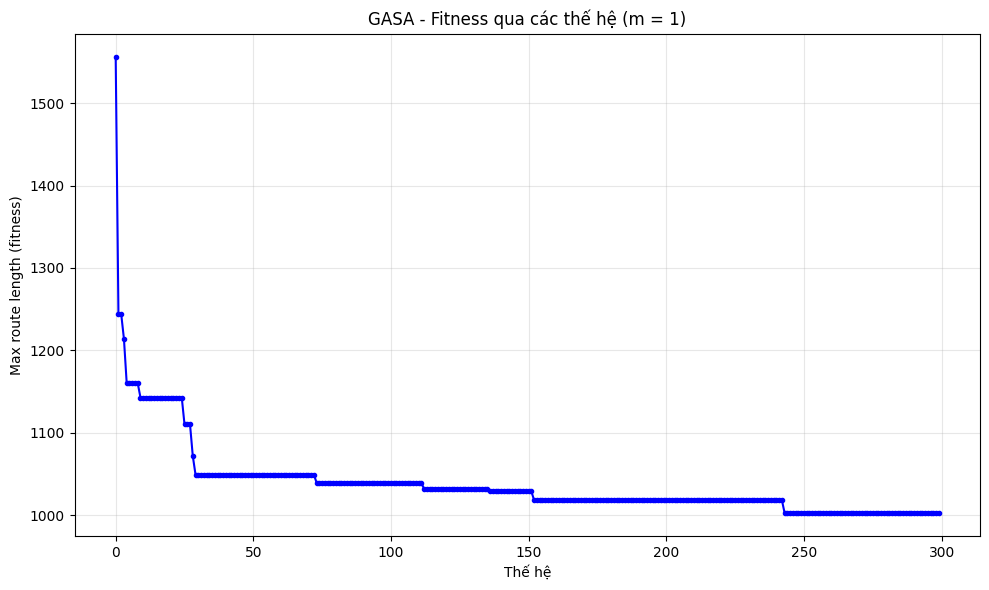


=== GASA - Số người bán hàng (m) = 2 ===
Gen 0: Best max route length = 843.70
Gen 20: Best max route length = 667.77
Gen 40: Best max route length = 663.30
Gen 60: Best max route length = 643.49
Gen 80: Best max route length = 609.89
Gen 100: Best max route length = 609.89
Gen 120: Best max route length = 605.52
Gen 140: Best max route length = 605.52
Gen 160: Best max route length = 602.17
Gen 180: Best max route length = 602.17
Gen 200: Best max route length = 602.17
Gen 220: Best max route length = 602.17
Gen 240: Best max route length = 602.17
Gen 260: Best max route length = 601.77
Gen 280: Best max route length = 589.00
Tổng quãng đường: 1175.70
Chiều dài route dài nhất (Max route length): 589.00
Chênh lệch giữa các route (Balance metric): 2.30
Thời gian thực thi: 12.7843 giây
Số vòng lặp cần thiết để hội tụ: 8
Tốc độ hội tụ: 31.8375 đơn vị/gen
 - Tuyến 1 (586.70): [0, 126, 51, 85, 114, 23, 94, 60, 11, 117, 59, 1, 46, 4, 64, 106, 24, 123, 84, 89, 48, 73, 120, 18, 10, 87, 20, 25

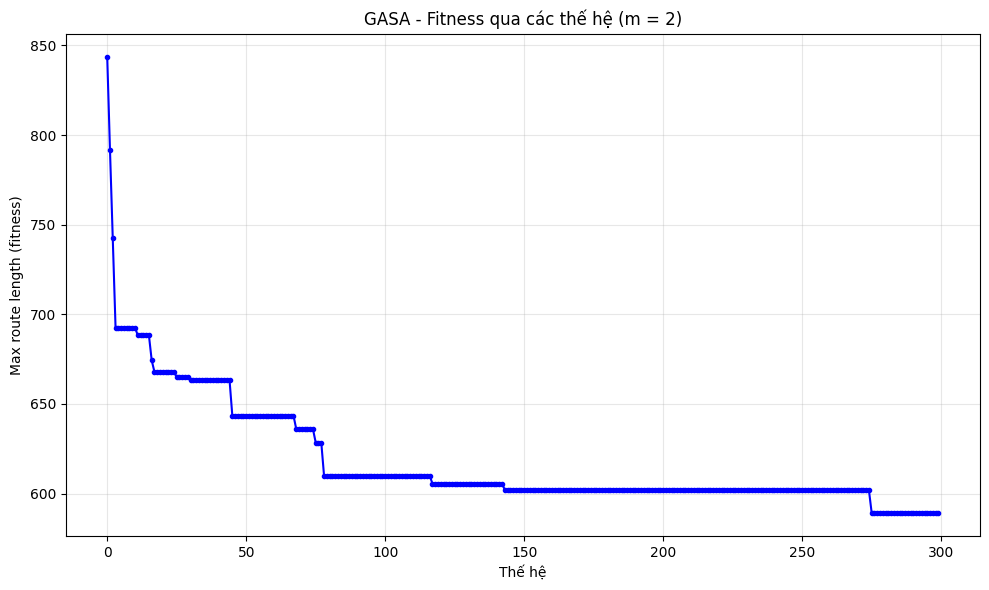


=== GASA - Số người bán hàng (m) = 3 ===
Gen 0: Best max route length = 596.86
Gen 20: Best max route length = 453.61
Gen 40: Best max route length = 446.00
Gen 60: Best max route length = 441.32
Gen 80: Best max route length = 441.32
Gen 100: Best max route length = 439.41
Gen 120: Best max route length = 439.41
Gen 140: Best max route length = 439.41
Gen 160: Best max route length = 439.41
Gen 180: Best max route length = 439.41
Gen 200: Best max route length = 439.41
Gen 220: Best max route length = 425.59
Gen 240: Best max route length = 425.59
Gen 260: Best max route length = 425.59
Gen 280: Best max route length = 425.59
Tổng quãng đường: 1253.63
Chiều dài route dài nhất (Max route length): 425.59
Chênh lệch giữa các route (Balance metric): 12.78
Thời gian thực thi: 11.6795 giây
Số vòng lặp cần thiết để hội tụ: 20
Tốc độ hội tụ: 8.5635 đơn vị/gen
 - Tuyến 1 (425.59): [0, 2, 68, 97, 106, 109, 37, 25, 93, 70, 107, 88, 8, 44, 67, 56, 22, 61, 21, 102, 71, 63, 14, 92, 30, 9, 78, 112,

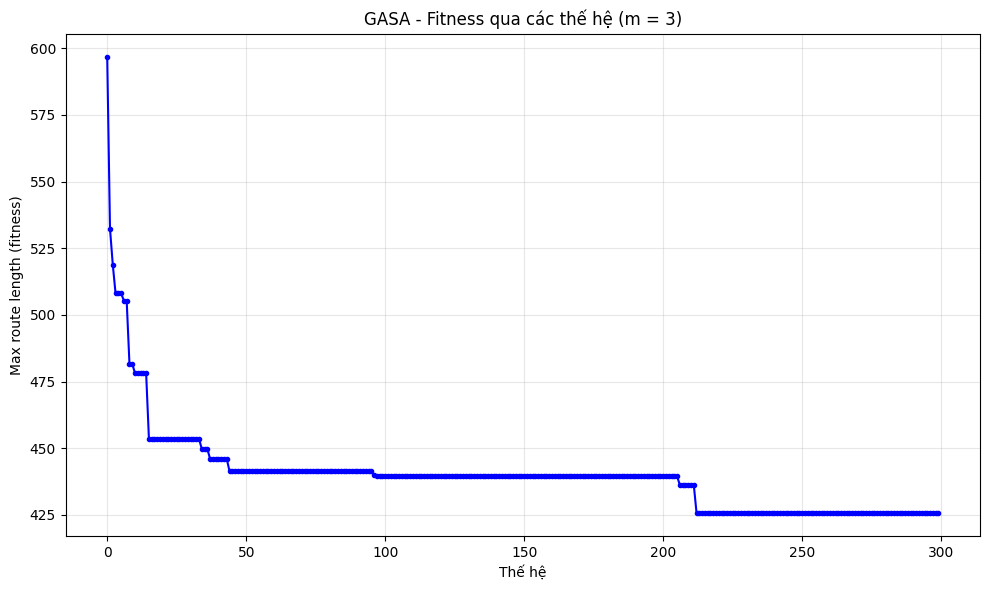

In [12]:
# Run experiments for different numbers of salesmen
for m in range(1, 4):
    print(f"\n=== GASA - Số người bán hàng (m) = {m} ===")

    start_time = time.time()

    gasa = GASA_mTSP(distance_matrix, m=m, pop_size=100, generations=300)
    routes, total_distance, max_route, balance_metric, fitness_per_generation = gasa.run()

    end_time = time.time()
    exec_time = end_time - start_time

    # Tính khoảng cách từng route
    route_distances = []
    for route in routes:
        if len(route) > 0:
            full_route = [0] + route + [0]
            distance = sum(distance_matrix[full_route[i]][full_route[i+1]] 
                           for i in range(len(full_route)-1))
            route_distances.append(distance)
        else:
            route_distances.append(0)

    # Chênh lệch giữa các route
    balance_metric = max(route_distances) - min(route_distances) if route_distances else 0

    # Phân tích hội tụ
    converged_gen = detect_convergence(fitness_per_generation)
    convergence_speed = (fitness_per_generation[0] - fitness_per_generation[-1]) / converged_gen if converged_gen > 0 else 0

    # In kết quả
    print(f"Tổng quãng đường: {total_distance:.2f}")
    print(f"Chiều dài route dài nhất (Max route length): {max_route:.2f}")
    print(f"Chênh lệch giữa các route (Balance metric): {balance_metric:.2f}")
    print(f"Thời gian thực thi: {exec_time:.4f} giây")
    print(f"Số vòng lặp cần thiết để hội tụ: {converged_gen}")
    print(f"Tốc độ hội tụ: {convergence_speed:.4f} đơn vị/gen")

    # Hiển thị từng route
    for i, route in enumerate(routes):
        if len(route) > 0:
            full_route = [0] + route + [0]
            print(f" - Tuyến {i+1} ({route_distances[i]:.2f}): {full_route}")
        else:
            print(f" - Tuyến {i+1} (0.00): [0]")

    # Vẽ biểu đồ fitness
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_per_generation, marker='o', linestyle='-', color='blue', markersize=3)
    plt.title(f"GASA - Fitness qua các thế hệ (m = {m})")
    plt.xlabel("Thế hệ")
    plt.ylabel("Max route length (fitness)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
